[View in Colaboratory](https://colab.research.google.com/github/ahmadayyad/IoTanomalydetection/blob/master/LSTM.ipynb)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving file_with_anamolies.csv to file_with_anamolies.csv


In [2]:
import pandas as pd
import pandas as pd
import io
from pandas import read_csv
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


<class 'pandas.core.frame.DataFrame'>
                     temp_C  humid_%
timestamp                           
2018-06-30 19:05:37   20.90    65.72
2018-06-30 19:06:10   20.95    65.58
2018-06-30 19:07:13   20.97    65.36
2018-06-30 19:07:43   21.02    65.28
2018-06-30 19:08:13   21.03    65.31
(9991, 2)
            temp_C      humid_%
count  9991.000000  9991.000000
mean     20.417435    56.432975
std       1.302566     5.019017
min     -12.650000    45.530000
25%      20.000000    52.620000
50%      20.340000    57.190000
75%      20.710000    58.880000
max      68.180000   105.410000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9e28fe6a0>,
      dtype=object)

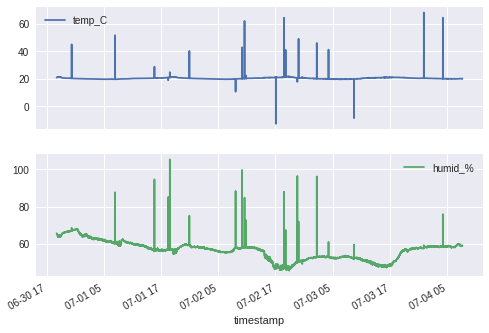

In [4]:
series=pd.DataFrame()
series=read_csv(io.StringIO(uploaded['file_with_anamolies.csv'].decode('utf-8')),sep=',',index_col=0, parse_dates=[0],squeeze=True)
series=series.loc[series['id']==1]
series.drop('id', axis=1, inplace=True)
series.drop('session', axis=1, inplace=True)
series.drop('iaq_acc', axis=1, inplace=True)
series.drop('inc', axis=1, inplace=True)
series.drop('iaq', axis=1, inplace=True)
print(type(series))
print(series.head())
print(series.shape)
#print(series['2018-06-30 19:05'])
print(series.describe())
#series['temp_C'].plot.line()
#series['humid_%'].plot.line()
series.plot(subplots=True)

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): 

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
values = series.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [15]:
n_mins = 10
n_features = 2
# frame as supervised learning
reframed = series_to_supervised(scaled, n_mins, 1)
print(reframed.shape)

(9981, 22)


In [50]:
values = reframed.values
n_train_mins = 6000
train = values[:n_train_mins, :]
test = values[n_train_mins:, :]
# split into input and outputs
n_obs = n_mins * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)


(6000, 20) 6000 (6000,)


In [51]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_mins, n_features))
test_X = test_X.reshape((test_X.shape[0], n_mins, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(test_X)

(6000, 10, 2) (6000,) (3981, 10, 2) (3981,)
[[[0.412718   0.08500332]
  [0.41284174 0.0870074 ]
  [0.41296542 0.0878424 ]
  ...
  [0.41395515 0.08533734]
  [0.41383147 0.08517039]
  [0.41358405 0.08617234]]

 [[0.41284174 0.0870074 ]
  [0.41296542 0.0878424 ]
  [0.41333658 0.08967942]
  ...
  [0.41383147 0.08517039]
  [0.41358405 0.08617234]
  [0.4134603  0.0870074 ]]

 [[0.41296542 0.0878424 ]
  [0.41333658 0.08967942]
  [0.41370773 0.08734131]
  ...
  [0.41358405 0.08617234]
  [0.4134603  0.0870074 ]
  [0.41308916 0.08917838]]

 ...

 [[0.40603733 0.2226119 ]
  [0.4059136  0.22361386]
  [0.4059136  0.22294593]
  ...
  [0.40603733 0.22444892]
  [0.40566617 0.2266199 ]
  [0.40603733 0.2249499 ]]

 [[0.4059136  0.22361386]
  [0.4059136  0.22294593]
  [0.40603733 0.22311288]
  ...
  [0.40566617 0.2266199 ]
  [0.40603733 0.2249499 ]
  [0.40616104 0.2242819 ]]

 [[0.4059136  0.22294593]
  [0.40603733 0.22311288]
  [0.4059136  0.22444892]
  ...
  [0.40603733 0.2249499 ]
  [0.40616104 0.2242

Train on 6000 samples, validate on 3981 samples
Epoch 1/50
 - 3s - loss: 0.0590 - val_loss: 0.0240
Epoch 2/50
 - 3s - loss: 0.0197 - val_loss: 0.0366
Epoch 3/50
 - 3s - loss: 0.0250 - val_loss: 0.0643
Epoch 4/50
 - 3s - loss: 0.0254 - val_loss: 0.0593
Epoch 5/50
 - 3s - loss: 0.0205 - val_loss: 0.0283
Epoch 6/50
 - 3s - loss: 0.0201 - val_loss: 0.0595
Epoch 7/50
 - 3s - loss: 0.0220 - val_loss: 0.0443
Epoch 8/50
 - 3s - loss: 0.0148 - val_loss: 0.0295
Epoch 9/50
 - 3s - loss: 0.0124 - val_loss: 0.0336
Epoch 10/50
 - 3s - loss: 0.0118 - val_loss: 0.0293
Epoch 11/50
 - 3s - loss: 0.0121 - val_loss: 0.0337
Epoch 12/50
 - 3s - loss: 0.0111 - val_loss: 0.0243
Epoch 13/50
 - 3s - loss: 0.0133 - val_loss: 0.0308
Epoch 14/50
 - 3s - loss: 0.0100 - val_loss: 0.0148
Epoch 15/50
 - 3s - loss: 0.0130 - val_loss: 0.0401
Epoch 16/50
 - 3s - loss: 0.0141 - val_loss: 0.0221
Epoch 17/50
 - 3s - loss: 0.0105 - val_loss: 0.0211
Epoch 18/50
 - 3s - loss: 0.0103 - val_loss: 0.0351
Epoch 19/50
 - 3s - loss:

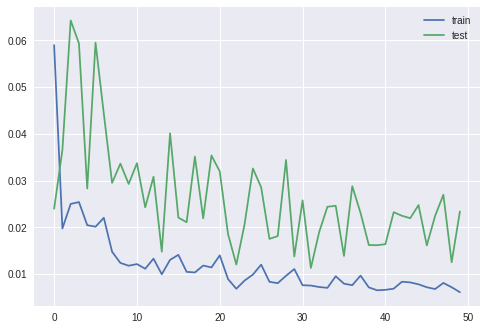

In [52]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [53]:
# make a prediction
yhat = model.predict(test_X)

print(yhat)
print(yhat.shape)
test_xx = test_X.reshape((test_X.shape[0], n_mins*n_features))
print(test_xx.shape)
inv_yhat = concatenate((yhat, test_xx[:, -1:]), axis=1)
print(inv_yhat.shape)

[[0.4282711 ]
 [0.42827636]
 [0.4282838 ]
 ...
 [0.437356  ]
 [0.43737745]
 [0.4374084 ]]
(3981, 1)
(3981, 20)
(3981, 2)


In [54]:

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:]
print(inv_yhat)



[[21.967155 50.69    ]
 [21.96758  50.74    ]
 [21.968182 50.87    ]
 ...
 [22.701487 59.      ]
 [22.703222 58.96    ]
 [22.70572  58.89    ]]


In [55]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
print(test_y.shape,test_X.shape)
inv_y = concatenate((test_y, test_xx[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:]
print(inv_y)

(3981, 1) (3981, 10, 2)
[[20.769999 50.69    ]
 [20.739998 50.74    ]
 [20.739998 50.87    ]
 ...
 [20.18     59.      ]
 [20.209997 58.96    ]
 [20.22     58.89    ]]


In [56]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.616
